# Проект: анализ причин оттока клиентов регионального банка

Цель исследования: снизить отток клиентов регионального банка благодаря выделению сегментов клиентов, которые наиболее склонны к уходу и формированию рекомендаций, которые помогут удержать эти сегменты.

Источник: срез данных по всем клиентам на 1.03.2021

Ссылка на презентацию: https://docs.google.com/presentation/d/14BsmW3wIZZ6cOEE4Audfai08c-4tFsxv1Zm9sQZWKPI/edit?usp=sharing

Ссылка на дашборд: https://public.tableau.com/views/_16779449423120/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Предобработка данных

In [1]:
#импортируем библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

In [2]:
#посмотрим на данные
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')
display(data.sort_values(by = 'userid'))
data.info()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
1287,15608437,698,Рыбинск,Ж,39,9,161993.89,1,0,0,90212.38,0
4198,15608442,612,Рыбинск,М,35,1,NaN,1,1,1,83256.26,1
7090,15608450,601,Ярославль,М,47,1,64430.06,2,0,1,96517.97,0
2020,15608515,627,Ростов Великий,Ж,30,6,57809.32,1,1,0,188258.49,0
3697,15608532,745,Ростов Великий,М,48,10,96048.55,1,1,0,74510.65,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3411,15858364,711,Ярославль,Ж,37,8,113899.92,1,0,0,80215.20,0
8271,15858381,481,Ярославль,М,37,8,152303.66,2,1,1,175082.20,0
8088,15858392,541,Ростов Великий,Ж,39,9,100116.67,1,1,1,199808.10,1
1762,15858396,758,Ярославль,Ж,34,1,154139.45,1,1,1,60728.89,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Видим 12 полей текстового и числового типа, в одном из них (Balance) есть пропуски.
Для удобства работы переименуем наименования колонок по-питоньему, приведем к единому виду.

In [3]:
data.rename(columns={'userid': 'user_id', 'City': 'city', 'Gender': 'gender', 'Age': 'age', 'Objects': 'objects', 'Balance': 'balance', 'Products': 'products', 'CreditCard': 'credit_card', 'Loyalty': 'loyalty', 'Churn': 'churn',}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Поле Balance, исходя из предоставленного описания данных, показывает баланс на счете клиента. Поскольку в этом поле есть пропуски, скорее всего, подразумеваются дебетовые средства. Например, у клиента может быть кредитная карта (один продукт) и не быть других продуктов (дебетовой карты). 

Проверим предположение: выберем клиентов, у которых только один продукт и при этом есть кредитная карта.

In [4]:
only_credit_card = data.query('credit_card == 1 and products == 1')
display(only_credit_card['balance'])

0             NaN
4       125510.82
9       134603.88
16      132602.88
22            NaN
          ...    
9991     88381.21
9992          NaN
9993    155060.41
9996     57369.61
9999    130142.79
Name: balance, Length: 3578, dtype: float64

Догадка не подтвердилась, у таких клиентов тоже есть как указанный, так и не указанный баланс. В любом случае оставим пропуски как есть: не будем заполнять ни медианным/средним значением (так как это будет некорректно), ни нулем/очень большим значением (в этом нет смысла при дальнейшем анализе). 

В рамках реального проекта мы бы запросили дополнительную информацию у сотрудника, который предоставил нам эти данные.

С типами данных в датасете тоже в целом все верно. В ходе предобработки мы будем добавлять в таблицу дополнительные столбцы, которые понадобятся в процессе анализа.

Посмотрим, есть ли дубликаты по user_id. Если есть, удалим их. Также посмотрим неявные дубликаты в названиях населенных пунктов.

In [5]:
data_uid_nodupl = data.drop_duplicates()
data_uid_nodupl.info()
print(data['city'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1015.6+ KB
['Ярославль' 'Рыбинск' 'Ростов Великий']


Видим, что дубликатов по user_id в датасете нет. Неявных дубликатов по названиям населенных пунктов также нет. Отлично, оставляем все как есть.

Создадим дополнительные бинарные столбцы: по всем городам и по полу со значениями 1/0 и переведем их в int тип данных.


In [6]:
#создаем столбец по полу
data['gender_bin'] = data['gender']
data.loc[data['gender_bin'] == 'Ж', 'gender_bin'] = 1
data.loc[data['gender_bin'] == 'М', 'gender_bin'] = 0
data = data.astype({'gender_bin': int})

#создаем столбец по городу "Ярославль"
data['yaroslavl_bin'] = data['city']
data.loc[data['yaroslavl_bin'] == 'Ярославль', 'yaroslavl_bin'] = 1
data.loc[(data['yaroslavl_bin'] == 'Рыбинск')|(data['yaroslavl_bin'] == 'Ростов Великий'), 'yaroslavl_bin'] = 0
data = data.astype({'yaroslavl_bin': int})

#создаем столбец по городу "Рыбинск"
data['rybinsk_bin'] = data['city']
data.loc[data['rybinsk_bin'] == 'Рыбинск', 'rybinsk_bin'] = 1
data.loc[(data['rybinsk_bin'] == 'Ярославль')|(data['rybinsk_bin'] == 'Ростов Великий'), 'rybinsk_bin'] = 0
data = data.astype({'rybinsk_bin': int})

#создаем столбец по городу "Ростов Великий"
data['rostovv_bin'] = data['city']
data.loc[data['rostovv_bin'] == 'Ростов Великий', 'rostovv_bin'] = 1
data.loc[(data['rostovv_bin'] == 'Рыбинск')|(data['rostovv_bin'] == 'Ярославль'), 'rostovv_bin'] = 0
data = data.astype({'rostovv_bin': int})

Для удобства дальнейшего анализа присвоим каждому заемщику категорию в соответствии с его кредитным рейтингом (score).
Судя по диапазону значений (350 - 850), в датасете использована старая шкала оценки рейтинга заемщиков НБКИ. 
Согласно этой шкале кредитного рейтинга, мы можем разделить заемщиков на четыре категории:
* 4 -- низкая степень кредитоспособности (300–629 баллов)
* 3 -- средняя степень кредитоспособности (630–689 баллов)
* 2 -- высокая степень кредитоспособности (690–719 баллов)
* 1 -- очень высокая степень кредитоспособности (720–850 баллов)

Напишем функцию.

In [7]:
def categorize_score(score):
    try:
        if 300 <= score <= 629:
            return '4'
        elif 630 <= score <= 689:
            return '3'
        elif 690 <= score <= 719:
            return '2'
        elif 720 <= score:
            return '1'
    except:
        pass

In [8]:
data['score_cat'] = data['score'].apply(categorize_score)
data = data.astype({'score_cat': int})

Мы завершили подготовительную работу. Теперь изучим данные подробнее: посмотрим на их распределение.

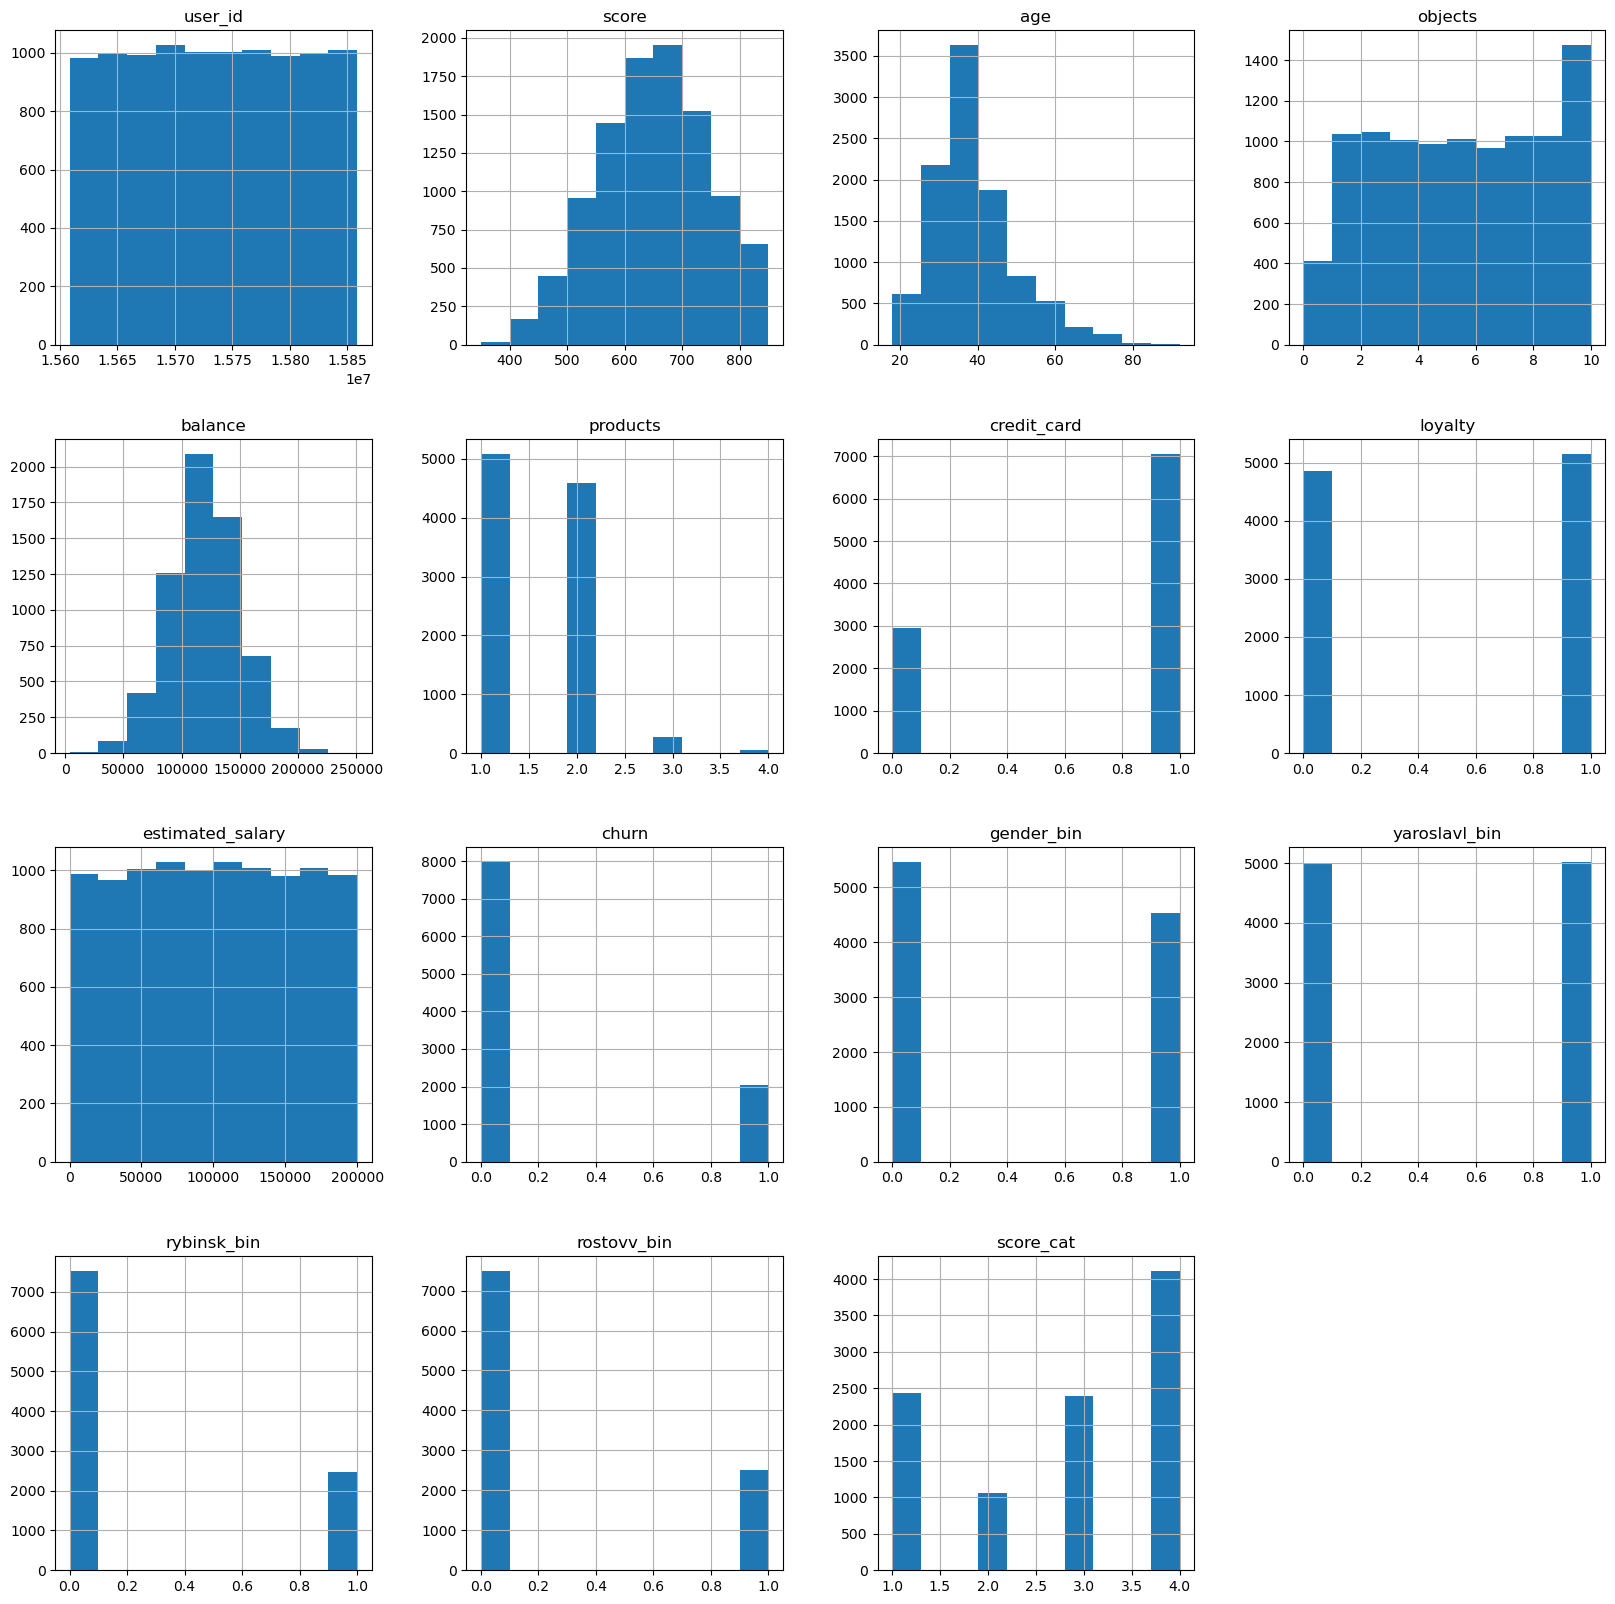

In [9]:
data.hist(figsize=(20, 20))
plt.show()

Итого у нас получилось 15 колонок. 
Сделаем промежуточные выводы после предобработки данных:
1. В столбце user_id видим небольшие всплески в некоторых диапазонах id. За неимением другой информации по датам привлечения клиентов, можем сделать предположение, что номера id выдаются по порядку и бОльшее количество номеров в каком-то диапазоне по сравнению с соседними может означать привлечение бОльшего количества клиентов за какой-то период. 
2. В столбце score (кредитный рейтинг заемщика) видим нормальное распределение, отметим что правый край чуть выше левого, что означает хорошую фильтрацию заемщиков. При этом в столбце score_cat видим как бы "отзеркаленное" нормальному распределение: меньше всего заемщиков 2 и 3 категорий, чуть больше -- самой надежной первой категории и больше всего (40%) попали в самую низкую 4ю категорию.
3. В столбце age видим также распределение, похожее на нормальное, с длинным хвостом справа и основной массой заемщиков 25-45 лет.
4. В столбце objects (объекты в собственности) видим, что количество заемщиков с 2-9 объектами примерно одинаковое (1000 по каждому числу), а вот с одним объектом заемщиков существенно меньше (400), и с 10 объектами существенно больше (~1400 человек). Скорее всего, это тоже связано со скорингом и вероятностью одобрения кредита. Чем больше объектов под залог -- тем выше вероятность.
5. В столбце balance у нас тоже нормальное распределение, что выглядит логичным.
6. в столбце products видим, что у >95% клиентов 1 или 2 продукта.
7. При этом из столбца credit_card видим, что кредитная карта есть у 70% клиентов.
8. Активные и не активные (столбец loyalty) клиенты поделились примерно поровну.
9. А вот столбец estimated_salary выглядит интересно. По логике распределение тоже должно быть нормальным: мало клиентов с низкой зарплатой, основная масса -- со средней, и мало клиентов -- с высокой. Может, дело в неточном распределении? Построили ниже отдельную гистограмму, картина в целом повторилась. 
10. 80% клиентов из датасета остаются в банке, 20% перестали ими быть. Многовато, дело в качестве привлекаемых клиентов или в том что банк не может их удержать?
11. Из столбца gender_bin видим что клиентов-мужчин немного больше, чем женщин. 
12. При этом половина клиентов из Ярославля, примерно по 25% -- из в. Ростова и Рыбинска.

<AxesSubplot:>

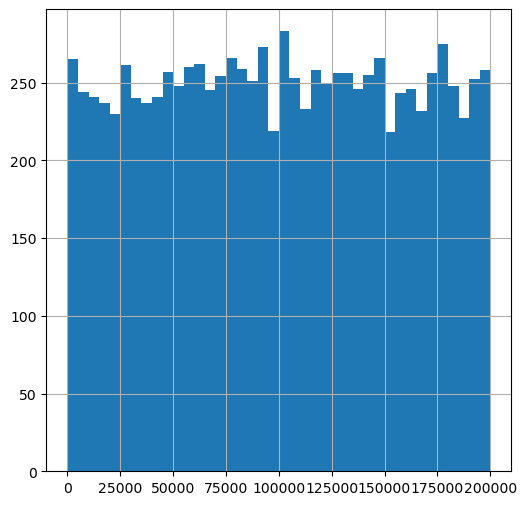

In [10]:
data['estimated_salary'].hist(bins = 40, figsize=(6, 6))


## Исследовательский анализ данных

Посмотрим на строки с пропусками в столбце balance. Визуализируем эту выборку через гистограммы, чтобы  посмотреть, нет ли у них каких-либо отличий от общего датасета.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3617 entries, 0 to 9997
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           3617 non-null   int64  
 1   score             3617 non-null   int64  
 2   city              3617 non-null   object 
 3   gender            3617 non-null   object 
 4   age               3617 non-null   int64  
 5   objects           3617 non-null   int64  
 6   balance           0 non-null      float64
 7   products          3617 non-null   int64  
 8   credit_card       3617 non-null   int64  
 9   loyalty           3617 non-null   int64  
 10  estimated_salary  3617 non-null   float64
 11  churn             3617 non-null   int64  
 12  gender_bin        3617 non-null   int32  
 13  yaroslavl_bin     3617 non-null   int32  
 14  rybinsk_bin       3617 non-null   int32  
 15  rostovv_bin       3617 non-null   int32  
 16  score_cat         3617 non-null   int32  


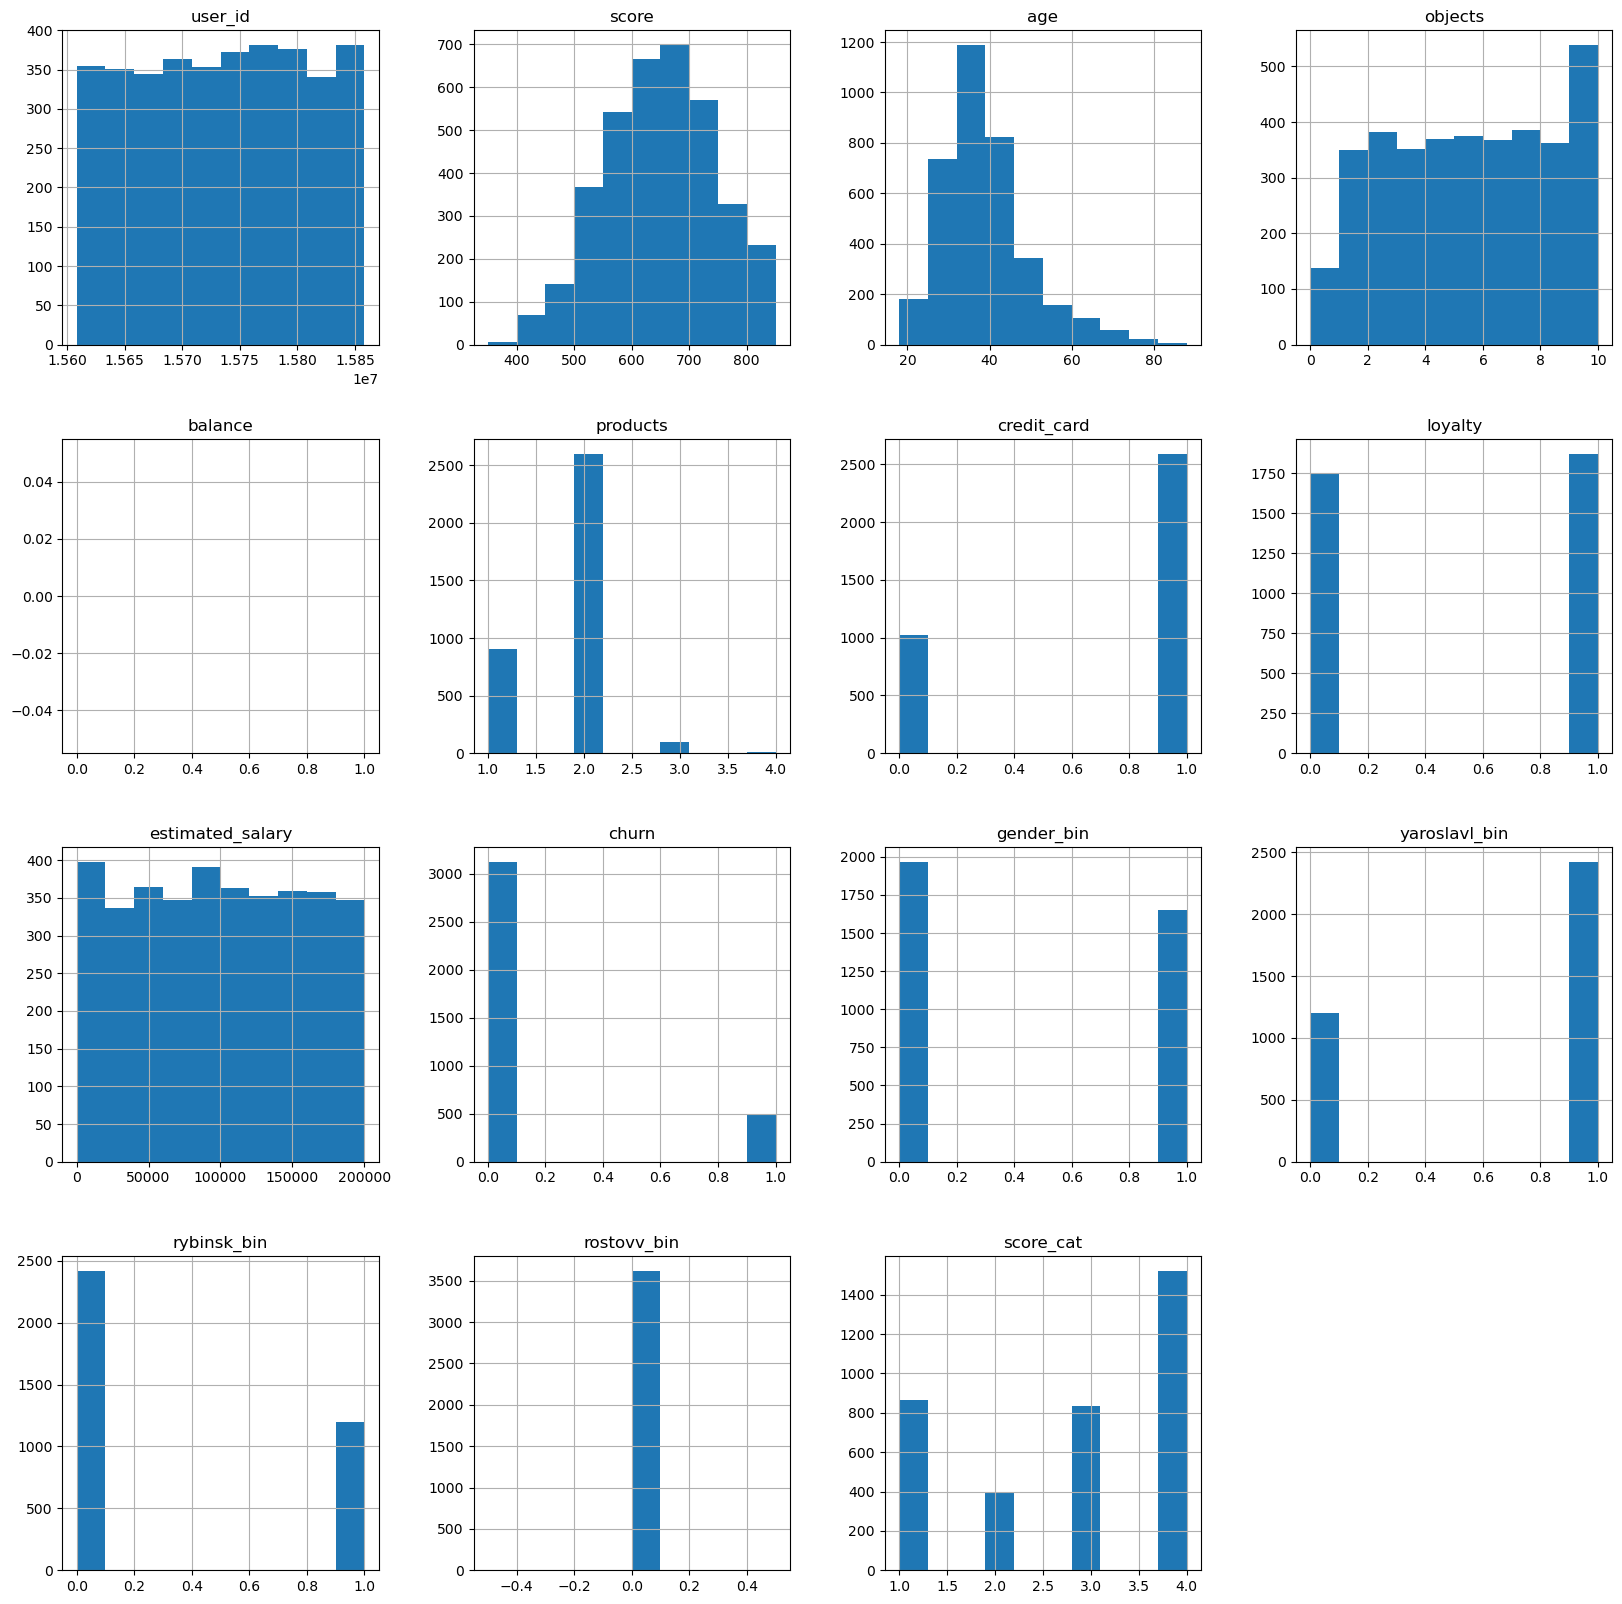

In [11]:
data_balance_nan =  data[data['balance'].isnull()]

data_balance_nan.info()
data_balance_nan.hist(figsize=(20, 20))
plt.show()

Выводы по гистограммам датасета с пропусками:
1. В целом видим всю ту же самую картину по распределениям данных.
2. Однако из 3617 клиентов данной выборки нет ни одного человека из в.Ростова!
3. Возможно, дело все же в качестве предоставленных данных.

Изучим распределение данных через боксплоты, чтобы выявить аномалии. Возьмем поля кредитной оценки, баланса и зарплаты, так как с остальными полями строить боксплот не имеет смысла ввиду однородности значений.

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64


(300.0, 1000.0)

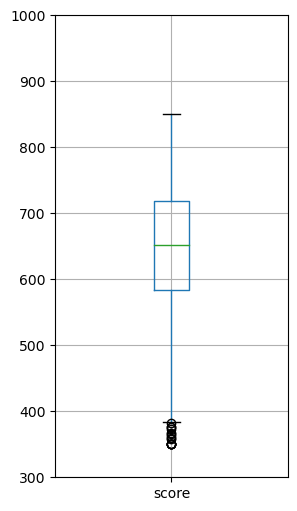

In [12]:
print(data['score'].describe())
boxplot = data.boxplot(column=['score'], figsize = (3,6))

#для увеличения масштаба изменим границы оси y
import matplotlib.pyplot as plt 
plt.ylim(300, 1000)

In [13]:
#посчитаем сколько значений лежат ниже усика боксплота
print(data.query('score < 390')['score'].count())

17


Судя по боксплоту видим 17 "аномально низких значений", но удалять их не будем, так как для данной колонки эти значения нормальны.  

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64


(3500.0, 255000.0)

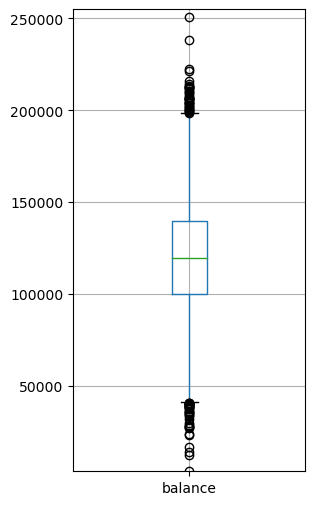

In [14]:
print(data['balance'].describe())
boxplot = data.boxplot(column=['balance'], figsize = (3,6))

import matplotlib.pyplot as plt 
plt.ylim(3500, 255000)


Вывод: среднее значение по балансу -- ~119827. Неплохо, учитывая минимальный показатель 3768.

count      9941.000000
mean     100680.924047
std       57165.944853
min        1002.390000
25%       51972.920000
50%      100720.020000
75%      149575.590000
max      199992.480000
Name: estimated_salary, dtype: float64


(-1000.0, 250000.0)

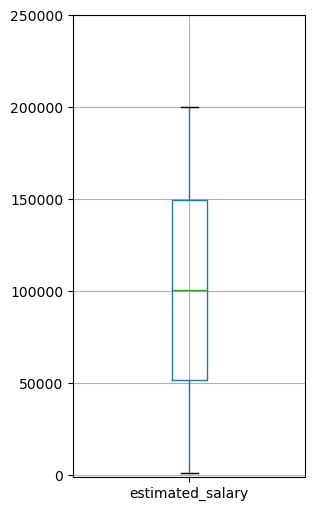

In [28]:
print(data['estimated_salary'].describe())
boxplot = data.boxplot(column=['estimated_salary'], figsize = (3,6))

import matplotlib.pyplot as plt 
plt.ylim(-1000, 250000)

Минимальное значение зарплаты -- 11,5; оно явно некорректно. Посмотрим сколько есть значений зарплаты меньше 1 000.

In [16]:
print(data.query('estimated_salary < 1000')['estimated_salary'].count())

59


Вывод: удаляем из датасета 59 строк с estimated_salary меньше 1000 (0,59% от общего числа значений).

In [17]:
data = data.query('estimated_salary >= 1000')

Исследуем корреляции между различными параметрами. Построим числовую матрицу корреляций.

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_bin,yaroslavl_bin,rybinsk_bin,rostovv_bin,score_cat
user_id,1.000000,0.006961,0.010805,-0.015239,-0.008346,0.015517,-0.013382,0.001606,0.014942,-0.005791,0.004652,-0.004329,0.007991,-0.002972,-0.006456
score,0.006961,1.000000,-0.005924,0.001036,-0.004954,0.013564,-0.007100,0.026499,-0.000927,-0.026893,0.000955,-0.008997,0.004223,0.006169,-0.898275
age,0.010805,-0.005924,1.000000,-0.010561,-0.013971,-0.030010,-0.011375,0.085665,-0.005718,0.285833,0.025924,-0.039842,-0.001747,0.047706,0.005774
objects,-0.015239,0.001036,-0.010561,1.000000,0.005870,0.013121,0.022941,-0.027767,0.009725,-0.015184,-0.013698,-0.002824,0.004099,-0.000828,-0.002226
balance,-0.008346,-0.004954,-0.013971,0.005870,1.000000,-0.001414,0.007722,-0.020047,-0.001910,0.016723,-0.025968,0.002332,-0.000179,-0.002199,-0.002859
products,0.015517,0.013564,-0.030010,0.013121,-0.001414,1.000000,0.004118,0.009453,0.013371,-0.046692,0.022627,0.001023,0.008848,-0.010001,-0.007311
credit_card,-0.013382,-0.007100,-0.011375,0.022941,0.007722,0.004118,1.000000,-0.012344,-0.010291,-0.006061,-0.006166,0.001455,-0.012788,0.011069,0.006140
loyalty,0.001606,0.026499,0.085665,-0.027767,-0.020047,0.009453,-0.012344,1.000000,-0.009584,-0.155659,-0.022887,0.002259,0.017521,-0.020073,-0.017518
estimated_salary,0.014942,-0.000927,-0.005718,0.009725,-0.001910,0.013371,-0.010291,-0.009584,1.000000,0.012678,0.008985,-0.001812,-0.009255,0.011316,-0.003675
churn,-0.005791,-0.026893,0.285833,-0.015184,0.016723,-0.046692,-0.006061,-0.155659,0.012678,1.000000,0.106844,-0.103390,-0.053014,0.172127,0.015418


Согласно шкале Чеддока, мы видим слабую (в диапазоне 0,1 -- 0,3) корреляцию поля churn с полями:

    возраст (с увеличением возраста возрастает риск ухода клиента)
    активность (если клиент не был активным за прошлый месяц, возрастает риск его ухода)
    пол (клиенты-мужчины уходят с меньшей вероятностью)
    город (клиенты из Ярославля и Рыбинска с большей вероятностью остаются в банке, клиенты из в.Ростова -- уходят)

Также можно отметить, что большое число открытых в банке продуктов, высокий скоринговый рейтинг также немного увеличивают вероятность того, что клиент останется в банке.

<AxesSubplot:xlabel='age', ylabel='Density'>

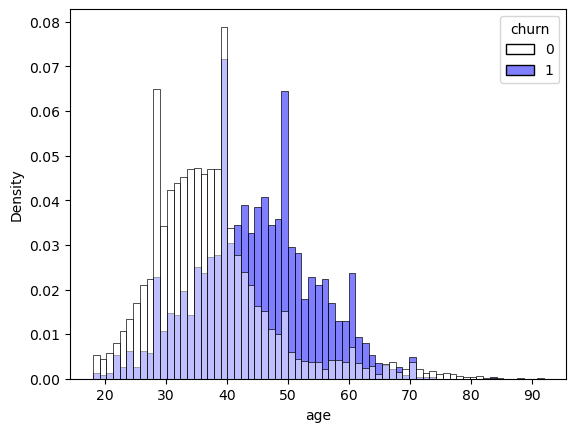

In [19]:
#строим нормализованную гистограмму по возрасту
sns.histplot(
data = data,
hue = "churn",
x = "age",
stat = "density",
common_norm = False,
palette = "flag",
)


Видим плотность вероятности распределения клиентов, которые ушли, и которые остались. Оставшиеся клиенты (белый цвет) с большой вероятностью находятся в диапазоне до 39 лет, ушедшие клиенты -- 40+ лет.

<AxesSubplot:xlabel='score', ylabel='Density'>

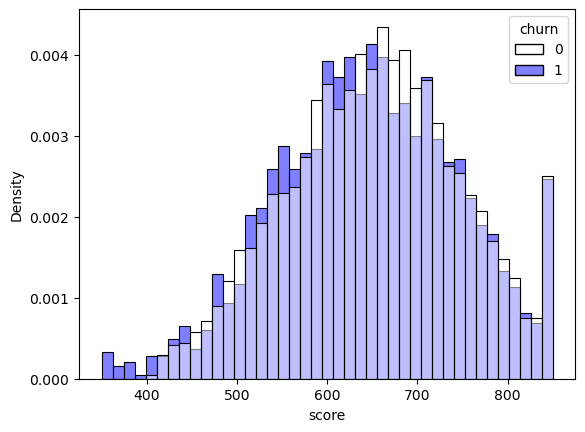

In [20]:
#строим нормализованную гистограмму по скорингу
sns.histplot(
data = data,
hue = "churn",
x = "score",
stat = "density",
common_norm = False,
palette = "flag",
)

В целом распределение равномерное. Видим белые кусочки (вероятность появления "оставшегося клиента" выше чем "ушедшего") преимущественно начиная с 650 баллов скоринга и выше. 

Также видим резкий всплеск вероятности у клиентов с высшим значением скоринга. Это вызвано небольшим количеством таких клиентов (2 было, 1 ушел 1 остался = картинка как на графике). 

<AxesSubplot:xlabel='gender_bin', ylabel='Density'>

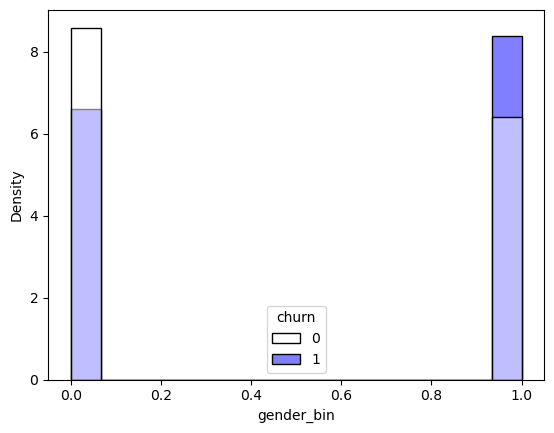

In [21]:
#строим нормализованную гистограмму по полу
sns.histplot(
data = data,
hue = "churn",
x = "gender_bin",
stat = "density",
common_norm = False,
palette = "flag",
)

Мужчины (белый кусочек слева) остаются с большей вероятностью, чем женщины.

<AxesSubplot:xlabel='loyalty', ylabel='Density'>

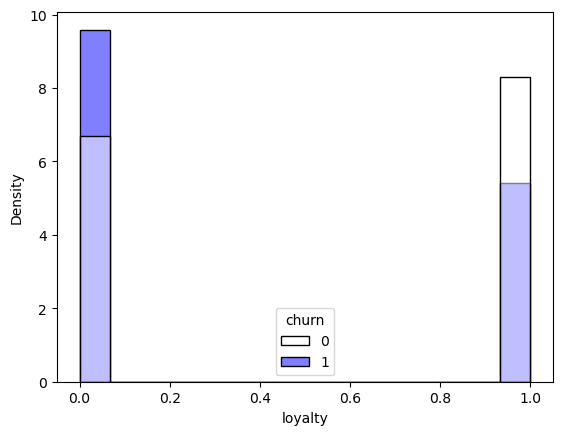

In [22]:
#строим нормализованную гистограмму по активности
sns.histplot(
data = data,
hue = "churn",
x = "loyalty",
stat = "density",
common_norm = False,
palette = "flag",
)

Активные в прошлом месяце клиенты (белый кусочек справа) остаются с большей вероятностью, чем не-активные.

<AxesSubplot:xlabel='city', ylabel='Density'>

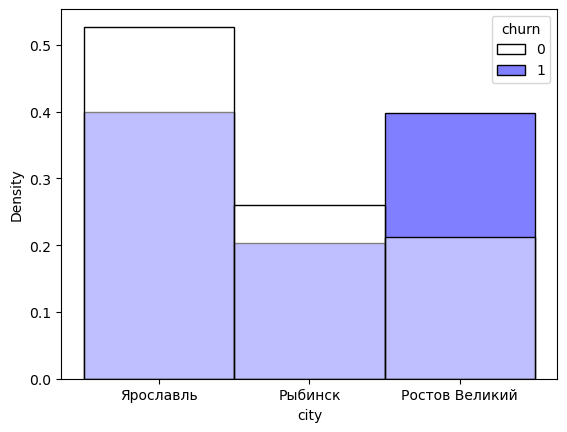

In [23]:
#строим нормализованную гистограмму по городам
sns.histplot(
data = data,
hue = "churn",
x = "city",
stat = "density",
common_norm = False,
palette = "flag",
)

Клиенты из Ярославля и Рыбинска остаются с большей вероятностью чем уходят, из в. Ростова -- наоборот.

<AxesSubplot:xlabel='objects', ylabel='Density'>

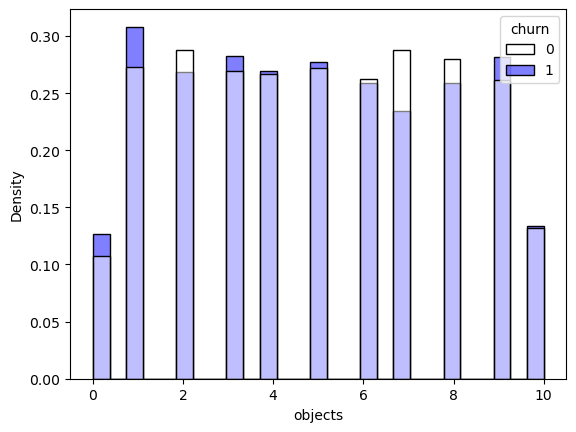

In [24]:
#строим нормализованную гистограмму по объектам в собственности
sns.histplot(
data = data,
hue = "churn",
x = "objects",
stat = "density",
common_norm = False,
palette = "flag",
)

Клиенты с 3,7 и 8 объектами в собственности остаются с большей вероятностью, чем все остальные.

На основе построенных выше графиков напишем портреты клиентов, склонных уходить из банка, а также клиентов "вне зоны риска" (остающихся в банке).

Портреты клиентов, склонных уйти из банка:

    возраст от 40 лет
    не был активным в течение последнего месяца
    скорее всего более низкая категория скоринга (3 или 4)
    скорее женщина (либо мужчина во второй приоритет)
    проживает в г. в.Ростов

Портреты клиентов, лояльных банку и хорошо удерживающихся:

    молодой, до 39 лет
    скорее мужчина (женщины во 2 приоритет)
    проживает в Ярославле (приоритет) либо в Рыбинске
    был активным в течение последнего месяца
    высокая категория скоринга (1 или 2)
    3,7 или 8 объектов в собственности и больше открытых продуктов


## Формулирование и проверка гипотез


Сформулируем гипотезы.

Гипотеза 1. H0: Доход людей, которые перестали быть клиентами банка, не отличается от дохода людей, которые остались клиентами банка. H1: Доход людей, которые перестали быть клиентами банка, отличается от дохода людей, которые остались клиентами банка.

Гипотеза 2. H0: Среди клиентов, которые остаются клиентами банка, доля людей с кредитной картой не выше чем среди клиентов, которые перестали быть клиентами банка. H1: Среди клиентов, которые остаются клиентами банка, доля людей с кредитной картой выше чем среди клиентов, которые перестали быть клиентами банка.

Разделим датасет на экспериментальные группы по полю churn


In [25]:
good_boys = data[data['churn'] == 0]
left_boys = data[data['churn'] == 1]


Для проверки первой гипотезы проведем t-тест и установим значение alpha = 5%. Это позволит обеспечить достаточную точность и при этом только 1 исследование из 20 будет давать ошибочно-ложный результат. 


Гипотеза 1:  Доход людей, которые перестали быть клиентами банка, и доход людей, которые остались клиентами банка, отличаются.

H_0: Доход (estimated_salary) людей, которые перестали быть клиентами банка (churn = 1) = доходу (estimated_salary) людей, которые остались клиентами банка (churn = 0).

H_a: Доход (estimated_salary) людей, которые перестали быть клиентами банка (churn = 1) ≠ доходу (estimated_salary) людей, которые остались клиентами банка (churn = 0). 

alpha = 0.05

In [26]:
results = st.ttest_ind(
   good_boys['estimated_salary'], 
   left_boys['estimated_salary'], equal_var = False) 

alpha = 0.05 
 
print( results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



0.20847652207299452
Не получилось отвергнуть нулевую гипотезу


Гипотеза 2:  Люди с кредитной картой с большей вероятностью остаются клиентами банка

H_0: Доля людей с кредитной картой (credit_card), которые перестали быть клиентами банка (churn = 1) = доле людей с кредитной картой (credit_card), которые остались клиентами банка (churn = 0).

H_a: Доля людей с кредитной картой (credit_card), которые перестали быть клиентами банка (churn = 1), меньше доли людей с кредитной картой (credit_card), которые остались клиентами банка (churn = 0).

alpha = 0.05

Для проверки этой гипотезы используем z-тест, т.к. сравниваем доли.
В данном случае мы проверяем одностороннюю гипотезу, то есть нам важно попадание в вероятность только с одной стороны. Поэтому делим получившееся p-value пополам. 
Если после деления p-value все равно будет больше уровня значимости, нулевую гипотезу отвергнуть мы не сможем.


In [27]:
gbcc= len(good_boys[good_boys['credit_card'] == 1])
gball = len(good_boys['credit_card'])
lbcc= len(left_boys[left_boys['credit_card'] == 1])
lball = len(left_boys['credit_card'])
alpha = 0.05
p1 = gbcc/gball
p2 = lbcc/lball

p_combined = (gbcc+lbcc)/(gball+lbcc)

difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/gball + 1/lball))

distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value/2)

if p_value/2 < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.26194170578540177
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Ни первую, ни вторую H0 не получилось отвергнуть.
Это значит, что ни доход, ни наличие кредитной карты не оказывают существенного влияния на удержание клиента. 

# Итоговый вывод и рекомендации

Мы провели анализ датасета регионального банка. В ходе предобработки данных выявили, что в поле "баланс" у порядка 30% клиентов есть пропуски, однако у клиентов из г. в.Ростов пропусков в этом поле нет. 

Также мы исследовали корреляцию различных параметров с полем churn, показывающим, удерживаем мы клиента или он ушел из банка. 

На основе этого мы построили портреты клиентов, склонных уходить из банка, а также клиентов "вне зоны риска" (остающихся в банке).

Портреты клиентов, склонных уйти из банка:
* возраст от 40 лет
* не был активным в течение последнего месяца
* скорее всего более низкая категория скоринга (3 или 4)
* скорее женщина (либо мужчина во второй приоритет)
* проживает в г. в.Ростов

Рекомендации по удержанию:
В первую очередь проверить качество обслуживания ростовских клиентов, так как абсолютное значение показателя корреляции к удержанию из всех городов здесь самое большое. 
Во вторую очередь -- продумать продукты, интересные людям с возрастной категорией 38-40 ++ лет. 
Это могут быть как повседневные бонусы (система кэшбека с категориями на выбор), так и продукты, рассчитанные на долгосрочное использование (страховые продукты, вклады, инвестиционные продукты, такие как брокерские счета и в частности ИИС).
В третью очередь -- предлагать клиентам, подходящим под такие портреты, новые продукты банка, такие как кредитная карта (с теми же категориями кэшбека), что соответствует их категории скоринга.

Портреты клиентов, лояльных банку и хорошо удерживающихся:
* молодой, до 39 лет
* скорее мужчина (женщины во 2 приоритет)
* проживает в Ярославле (приоритет) либо в Рыбинске
* был активным в течение последнего месяца
* высокая категория скоринга (1 или 2)
* 3,7 или 8 объектов в собственности и больше открытых продуктов

Рекомендации по удержанию: 
В первую очередь конечно же привлекать больше таких клиентов и внимательно отслеживать качество обслуживания. Возможно, добавить услугу "персонального менеджера".
Во вторую очередь продумать отдельную систему премиальных продуктов для таких клиентов: кредиты по сниженным ставкам (выше категория скоринга = меньше риск невозврата = банк может сделать скидку) и т.д.
В третью очередь, провести касдевы и анализ конкурентов, чтобы понять, как выглядеть для данного сегмента привлекательнее, чем другие банки.
